Quantum Cryptography: Quantum Key Distribution

In [1]:
import qiskit
#other useful packages
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Import Qiskit
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

Part 1: Encrypting and Decrypting a Message

In [2]:
#Super secret message
mes = 'hello world'
print('Your super secret message: ',mes)

#initial size of key
n = len(mes)*3

#break up message into smaller parts if length > 10
nlist = []
for i in range(int(n/10)):
    nlist.append(10)
if n%10 != 0:
    nlist.append(n%10)

print('Initial key length: ',n)

Your super secret message:  hello world
Initial key length:  33


Step 1: Alice Generates a Random Key

In [3]:
# Make random strings of length string_length

def randomStringGen(string_length):
    #output variables used to access quantum computer results at the end of the function
    output_list = []
    output = ''
    
    #start up your quantum circuit information
    backend = BasicAer.get_backend('qasm_simulator')  
    circuits = ['rs']
    
    #run circuit in batches of 10 qubits for fastest results. The results
    #from each run will be appended and then clipped down to the right n size.
    n = string_length
    temp_n = 10
    temp_output = ''
    for i in range(math.ceil(n/temp_n)):
        #initialize quantum registers for circuit
        q = QuantumRegister(temp_n, name='q')
        c = ClassicalRegister(temp_n, name='c')
        rs = QuantumCircuit(q, c, name='rs')
            
        #create temp_n number of qubits all in superpositions
        for i in range(temp_n):
            rs.h(q[i]) #the .h gate is the Hadamard gate that makes superpositions
            rs.measure(q[i],c[i])

        #execute circuit and extract 0s and 1s from key
        result = execute(rs, backend, shots=1).result()
        counts = result.get_counts(rs)
        result_key = list(result.get_counts(rs).keys())
        temp_output = result_key[0]
        output += temp_output
        
    #return output clipped to size of desired string length
    return output[:n]

In [4]:
key = randomStringGen(n)
print('Initial key: ',key)

Initial key:  101101111101110111110111101001000


Steps 2-4: Send Alice's Qubits to Bob

In [5]:
#generate random rotation strings for Alice and Bob
Alice_rotate = randomStringGen(n)
Bob_rotate = randomStringGen(n)
print("Alice's rotation string:",Alice_rotate)
print("Bob's rotation string:  ",Bob_rotate)

#start up your quantum program
backend = BasicAer.get_backend('qasm_simulator')  
shots = 1
circuits = ['send_over']
Bob_result = ''

for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Ar_temp = Alice_rotate[10*ind:10*ind+l]
        Br_temp = Bob_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Ar_temp = Alice_rotate[l*ind:l*(ind+1)]
        Br_temp = Bob_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum circuit information
    q = QuantumRegister(l, name='q')
    c = ClassicalRegister(l, name='c')
    send_over = QuantumCircuit(q, c, name='send_over')
    
    #prepare qubits based on key; add Hadamard gates based on Alice's and Bob's
    #rotation strings
    for i,j,k,n in zip(key_temp,Ar_temp,Br_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        k = int(k)
        if i > 0:
            send_over.x(q[n])
        #Look at Alice's rotation string
        if j > 0:
            send_over.h(q[n])
        #Look at Bob's rotation string
        if k > 0:
            send_over.h(q[n])
        send_over.measure(q[n],c[n])

    #execute quantum circuit
    result_so = execute([send_over], backend, shots=shots).result()
    counts_so = result_so.get_counts(send_over)
    result_key_so = list(result_so.get_counts(send_over).keys())
    Bob_result += result_key_so[0][::-1]
    
print("Bob's results: ", Bob_result)

Alice's rotation string: 100100011100011100000010000111101
Bob's rotation string:   010000001000010010111100100111011
Bob's results:  111001101101111111011111001001100


Steps 5-6: Compare Rotation Strings and Make Keys

In [7]:
def makeKey(rotation1,rotation2,results):
    key = ''
    count = 0
    for i,j in zip(rotation1,rotation2):
        if i == j:
            key += results[count]
        count += 1
    return key
  
Akey = makeKey(Bob_rotate,Alice_rotate,key)
Bkey = makeKey(Bob_rotate,Alice_rotate,Bob_result)

print("Alice's key:",Akey)
print("Bob's key:  ",Bkey)

Alice's key: 10111011111010010
Bob's key:   10111011111010010


Encrypt (and decrypt) using quantum key

In [8]:
#make key same length has message
shortened_Akey = Akey[:len(mes)]
encoded_m=''

#encrypt message mes using encryption key final_key
for m,k in zip(mes,shortened_Akey):
    encoded_c = chr(ord(m) + 2*ord(k) % 256)
    encoded_m += encoded_c
print('encoded message:  ',encoded_m)

#make key same length has message
shortened_Bkey = Bkey[:len(mes)]

#decrypt message mes using encryption key final_key
result = ''
for m,k in zip(encoded_m,shortened_Bkey):
    encoded_c = chr(ord(m) - 2*ord(k) % 256)
    result += encoded_c
print('recovered message:',result)

encoded message:   ÊÅÎÎÑÙÑÔÎÆ
recovered message: hello world


In [9]:
#Colocar em Outro Tutorial


Part 2: Eve the Eavesdropper

Step 1: Eve intercepts Alice's transmission

In [10]:
#start up your quantum program
backend = BasicAer.get_backend('qasm_simulator')  
shots = 1
circuits = ['Eve']

Eve_result = ''
for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Ar_temp = Alice_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Ar_temp = Alice_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum circuit information
    q = QuantumRegister(l, name='q')
    c = ClassicalRegister(l, name='c')
    Eve = QuantumCircuit(q, c, name='Eve')
    
    #prepare qubits based on key; add Hadamard gates based on Alice's and Bob's
    #rotation strings
    for i,j,n in zip(key_temp,Ar_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        if i > 0:
            Eve.x(q[n])
        if j > 0:
            Eve.h(q[n])
        Eve.measure(q[n],c[n])
    
    #execute
    result_eve = execute(Eve, backend, shots=shots).result()
    counts_eve = result_eve.get_counts()
    result_key_eve = list(result_eve.get_counts().keys())
    Eve_result += result_key_eve[0][::-1]

print("Eve's results: ", Eve_result)

Eve's results:  101101110101100011110111101111001


Step 2: Eve deceives Bob

In [11]:
#start up your quantum program
backend = BasicAer.get_backend('qasm_simulator')  
shots = 1
circuits = ['Eve2']

Bob_badresult = ''
for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Eve_temp = Eve_result[10*ind:10*ind+l]
        Br_temp = Bob_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Eve_temp = Eve_result[l*ind:l*(ind+1)]
        Br_temp = Bob_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum circuit information
    q = QuantumRegister(l, name='q')
    c = ClassicalRegister(l, name='c')
    Eve2 = QuantumCircuit(q , c, name='Eve2')
    
    #prepare qubits
    for i,j,n in zip(Eve_temp,Br_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        if i > 0:
            Eve2.x(q[n])
        if j > 0:
            Eve2.h(q[n])
        Eve2.measure(q[n],c[n])
    
    #execute
    result_eve = execute(Eve2, backend, shots=shots).result()
    counts_eve = result_eve.get_counts()
    result_key_eve = list(result_eve.get_counts().keys())
    Bob_badresult += result_key_eve[0][::-1]
    
print("Bob's previous results (w/o Eve):",Bob_result)
print("Bob's results from Eve:\t\t ",Bob_badresult)

Bob's previous results (w/o Eve): 111001101101111111011111001001100
Bob's results from Eve:		  111101111101100011010111001100010


Step 4: Spot Check

In [12]:
#make keys for Alice and Bob
Akey = makeKey(Bob_rotate,Alice_rotate,key)
Bkey = makeKey(Bob_rotate,Alice_rotate,Bob_badresult)
print("Alice's key:   ",Akey)
print("Bob's key:     ",Bkey)

check_key = randomStringGen(len(Akey))
print('spots to check:',check_key)

Alice's key:    10111011111010010
Bob's key:      10111011011011000
spots to check: 00100101100001000


Steps 5-7: Compare strings and detect Eve

In [13]:
#find which values in rotation string were used to make the key
Alice_keyrotate = makeKey(Bob_rotate,Alice_rotate,Alice_rotate)
Bob_keyrotate = makeKey(Bob_rotate,Alice_rotate,Bob_rotate)

# Detect Eve's interference
#extract a subset of Alice's key
sub_Akey = ''
sub_Arotate = ''
count = 0
for i,j in zip(Alice_rotate,Akey):
    if int(check_key[count]) == 1:
        sub_Akey += Akey[count]
        sub_Arotate += Alice_keyrotate[count]
    count += 1

#extract a subset of Bob's key
sub_Bkey = ''
sub_Brotate = ''
count = 0
for i,j in zip(Bob_rotate,Bkey):
    if int(check_key[count]) == 1:
        sub_Bkey += Bkey[count]
        sub_Brotate += Bob_keyrotate[count]
    count += 1
print("subset of Alice's key:",sub_Akey)
print("subset of Bob's key:  ",sub_Bkey)

#compare Alice and Bob's key subsets
secure = True
for i,j in zip(sub_Akey,sub_Bkey):
    if i == j:
        secure = True
    else:
        secure = False
        break;
if not secure:
    print('Eve detected!')
else:
    print('Eve escaped detection!')

#sub_Akey and sub_Bkey are public knowledge now, so we remove them from Akey and Bkey
if secure:
    new_Akey = ''
    new_Bkey = ''
    for index,i in enumerate(check_key):
        if int(i) == 0:
            new_Akey += Akey[index]
            new_Bkey += Bkey[index]
    print('new A and B keys: ',new_Akey,new_Bkey)
    if(len(mes)>len(new_Akey)):
        print('Your new key is not long enough.')

subset of Alice's key: 10110
subset of Bob's key:   10101
Eve detected!


Probability of Detecting Eve

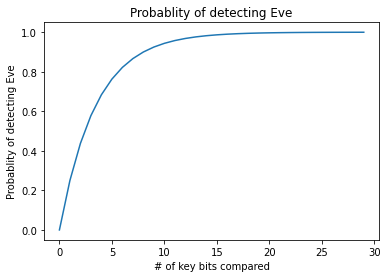

In [14]:
#!!! you may need to execute this cell twice in order to see the output due to an problem with matplotlib
x = np.arange(0., 30.0)
y = 1-(3/4)**x
plt.plot(y)
plt.title('Probablity of detecting Eve')
plt.xlabel('# of key bits compared')
plt.ylabel('Probablity of detecting Eve')
plt.show()